In [44]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import squarify
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium

import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.stats import kstest, norm
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import chi2_contingency

# Now you can use chi2_contingency function in your code


#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

![Image](https://drive.google.com/uc?export=view&id=1FDWY3xNgo3ounB-QJaQazWJloBqTKd0B)


In [3]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from vehicles
    inner join districts on vehicles.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
vehicles = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
vehicles.sort_values(by='id', ascending=True, inplace=True)
vehicles.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'vehicles' DataFrame with the 'dim_date' DataFrame on the 'month' column
vehicles = pd.merge(vehicles, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame

# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)
vehicles.head()

id dist_code       month  fuel_type_petrol  fuel_type_diesel  \
0   1      15_1  2019-04-01             17910              3011   
1   2      18_2  2019-04-01              3066               306   
2   3      20_3  2019-04-01              1577               215   
3   4      21_3  2019-04-01              1961               281   
4   5      21_7  2019-04-01              1552               309   

   fuel_type_electric  fuel_type_others  vehicleClass_MotorCycle  \
0                  76                22                    15308   
1                   6                 0                     2995   
2                   0                 0                     1546   
3                   2                 0                     1939   
4                   0                 0                     1512   

   vehicleClass_MotorCar  vehicleClass_AutoRickshaw  vehicleClass_Agriculture  \
0                   4429                          0                         4   
1                    142                         49                        64   
2                     79                         29                        21   
3                     72                         72                        48   
4                     76                         69                       109   

   vehicleClass_others  seatCapacity_1_to_3  seatCapacity_4_to_6  \
0                 1278                16110                 4182   
1                  128                 3156                  189   
2                  117                 1683                  104   
3                  113                 2082                  146   
4                   95                 1696                  145   

   seatCapacity_above_6  brand_new_vehicles  pre_owned_vehicles  \
0                   717               19542                1477   
1                    33                3322                  56   
2                     5                1751                  41   
3                    16                2209                  35   
4                    20                1820                  41   

   category_non_transport  category_transport dist_code  \
0                   19856                1163      15_1   
1                    3203                 175      18_2   
2                    1648                 144      20_3   
3                    2075                 169      21_3   
4                    1701                 160      21_7   

                    district  mmm quarter  fiscal_year  
0               Rangareddy\r  Apr      Q1         2019  
1                Kamareddy\r  Apr      Q1         2019  
2         Rajanna Sircilla\r  Apr      Q1         2019  
3                  Jangoan\r  Apr      Q1         2019  
4  Jayashankar Bhupalpally\r  Apr      Q1         2019

In [4]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

vehicles['district'] = vehicles['district'].str.replace('\r', '')

# drop dis_code
vehicles.drop(columns=['dist_code','dist_code'], inplace=True)

vehicles.head()

id       month  fuel_type_petrol  fuel_type_diesel  fuel_type_electric  \
0   1  2019-04-01             17910              3011                  76   
1   2  2019-04-01              3066               306                   6   
2   3  2019-04-01              1577               215                   0   
3   4  2019-04-01              1961               281                   2   
4   5  2019-04-01              1552               309                   0   

   fuel_type_others  vehicleClass_MotorCycle  vehicleClass_MotorCar  \
0                22                    15308                   4429   
1                 0                     2995                    142   
2                 0                     1546                     79   
3                 0                     1939                     72   
4                 0                     1512                     76   

   vehicleClass_AutoRickshaw  vehicleClass_Agriculture  vehicleClass_others  \
0                          0                         4                 1278   
1                         49                        64                  128   
2                         29                        21                  117   
3                         72                        48                  113   
4                         69                       109                   95   

   seatCapacity_1_to_3  seatCapacity_4_to_6  seatCapacity_above_6  \
0                16110                 4182                   717   
1                 3156                  189                    33   
2                 1683                  104                     5   
3                 2082                  146                    16   
4                 1696                  145                    20   

   brand_new_vehicles  pre_owned_vehicles  category_non_transport  \
0               19542                1477                   19856   
1                3322                  56                    3203   
2                1751                  41                    1648   
3                2209                  35                    2075   
4                1820                  41                    1701   

   category_transport                 district  mmm quarter  fiscal_year  
0                1163               Rangareddy  Apr      Q1         2019  
1                 175                Kamareddy  Apr      Q1         2019  
2                 144         Rajanna Sircilla  Apr      Q1         2019  
3                 169                  Jangoan  Apr      Q1         2019  
4                 160  Jayashankar Bhupalpally  Apr      Q1         2019

In [5]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         1440 non-null   int64 
 1   month                      1440 non-null   object
 2   fuel_type_petrol           1440 non-null   int64 
 3   fuel_type_diesel           1440 non-null   int64 
 4   fuel_type_electric         1440 non-null   int64 
 5   fuel_type_others           1440 non-null   int64 
 6   vehicleClass_MotorCycle    1440 non-null   int64 
 7   vehicleClass_MotorCar      1440 non-null   int64 
 8   vehicleClass_AutoRickshaw  1440 non-null   int64 
 9   vehicleClass_Agriculture   1440 non-null   int64 
 10  vehicleClass_others        1440 non-null   int64 
 11  seatCapacity_1_to_3        1440 non-null   int64 
 12  seatCapacity_4_to_6        1440 non-null   int64 
 13  seatCapacity_above_6       1440 non-null   int64 
 14  brand_ne

In [6]:
# change date to datetime type

vehicles['month'] = pd.to_datetime(vehicles['month'])

In [7]:
vehicles.describe()

id  fuel_type_petrol  fuel_type_diesel  fuel_type_electric  \
count  1440.000000       1440.000000       1440.000000         1440.000000   
mean    720.500000       3835.600694        659.294444           71.985417   
std     415.836506       5245.789804        684.823903          247.599599   
min       1.000000          0.000000          0.000000            0.000000   
25%     360.750000       1346.250000        261.750000            2.000000   
50%     720.500000       2067.500000        445.500000            8.000000   
75%    1080.250000       3412.000000        744.000000           35.000000   
max    1440.000000      39689.000000       5270.000000         2782.000000   

       fuel_type_others  vehicleClass_MotorCycle  vehicleClass_MotorCar  \
count       1440.000000              1440.000000            1440.000000   
mean          62.131250              3340.268750             719.743056   
std          204.991263              4349.406167            1455.487272   
min            0.000000                 0.000000               0.000000   
25%            2.000000              1229.750000             123.000000   
50%            6.000000              1887.000000             228.500000   
75%           34.000000              3149.250000             432.500000   
max         2326.000000             35420.000000            8036.000000   

       vehicleClass_AutoRickshaw  vehicleClass_Agriculture  \
count                1440.000000               1440.000000   
mean                   93.850694                135.912500   
std                   197.178758                118.486063   
min                     0.000000                  0.000000   
25%                    16.000000                 49.000000   
50%                    36.000000                105.000000   
75%                    90.000000                189.000000   
max                  2287.000000                786.000000   

       vehicleClass_others  seatCapacity_1_to_3  seatCapacity_4_to_6  \
count          1440.000000          1440.000000          1440.000000   
mean            339.327778          3750.516667           768.715278   
std             449.467763          4609.407242          1413.933293   
min               0.000000             6.000000             0.000000   
25%             122.000000          1486.250000           154.000000   
50%             199.000000          2244.500000           273.000000   
75%             332.250000          3635.500000           543.500000   
max            4299.000000         36694.000000          7918.000000   

       seatCapacity_above_6  brand_new_vehicles  pre_owned_vehicles  \
count           1440.000000         1440.000000         1440.000000   
mean             108.190278         4317.778472          311.343056   
std              209.771880         5531.411539          648.260389   
min                0.000000            6.000000            0.000000   
25%               20.000000         1629.750000           57.000000   
50%               38.000000         2457.000000          101.000000   
75%               75.250000         4095.250000          167.000000   
max             1337.000000        42073.000000         4450.000000   

       category_non_transport  category_transport  fiscal_year  
count             1440.000000         1440.000000  1440.000000  
mean              4213.104861          416.016667  2020.500000  
std               5693.800420          525.924176     1.118422  
min                  6.000000            0.000000  2019.000000  
25%               1497.000000          149.000000  2019.750000  
50%               2295.000000          250.000000  2020.500000  
75%               3783.250000          449.250000  2021.250000  
max              42074.000000         4239.000000  2022.000000

### General Overview

- The dataset consists of 1440 records.
- The data spans from April 2019 to March 2023.

### Fuel Type

#### Petrol
- The average number of petrol vehicles is around 3835.6, with a wide range from 0 to 39689. 
- The standard deviation is quite high (5245.79), indicating a significant variation in the number of petrol vehicles over the period.

#### Diesel
- On average, there are about 659.3 diesel vehicles. 
- The range is from 0 to 5270, and the standard deviation is 684.82, suggesting some variability but not as much as petrol vehicles.

#### Electric
- Electric vehicles have an average count of 72, with a maximum of 2782. 
- This indicates that while electric vehicles are present, they are not as prevalent as petrol or diesel vehicles.

#### Others
- The other types of fuel vehicles have an average of 62.13, with a maximum of 2326.

### Vehicle Class

#### MotorCycle
- The most common vehicle class with an average of 3340.27, ranging from 0 to 35420.

#### MotorCar
- Averages at 719.74 with a maximum of 8036.

#### AutoRickshaw
- Average count is 93.85, with some months having none and others having as many as 2287.

#### Agriculture
- Averages at 135.91, with a maximum of 786.

#### Others
- Other vehicle classes average at 339.33, with a maximum of 4299.

### Seat Capacity

#### 1 to 3
- The most common seating capacity, averaging at 3750.52.

#### 4 to 6
- Averages at 768.71.

#### Above 6
- Less common with an average of 108.19.

### Vehicle Condition

#### Brand New Vehicles
- On average, there are 4317.78 brand new vehicles, with a maximum of 42073.

#### Pre-Owned Vehicles
- Averages at 311.34, with a maximum of 4450.

### Category

#### Non-Transport
- Averages at 4213.10, with a maximum of 42074.

#### Transport
- Averages at 416.02, with a maximum of 4239.

### Fiscal Year

- The data spans from the fiscal year 2019 to 2022.

## Key Takeaways

- Petrol vehicles are the most common, but there's a significant variation in their numbers.
- Motorcycles are the most prevalent vehicle class.
- Vehicles with a seating capacity of 1 to 3 are the most common.
- Brand new vehicles are more common than pre-owned ones.
- Non-transport vehicles dominate the dataset compared to transport vehicles.


In [8]:
# Load the GeoJSON data
map_file = (r"D:\Telangana_Growth_Analysis\Telangana_Shape_Files\telangana_district_map.json")
geo_data = gpd.read_file(map_file)

In [9]:
vehicles.head()

id      month  fuel_type_petrol  fuel_type_diesel  fuel_type_electric  \
0   1 2019-04-01             17910              3011                  76   
1   2 2019-04-01              3066               306                   6   
2   3 2019-04-01              1577               215                   0   
3   4 2019-04-01              1961               281                   2   
4   5 2019-04-01              1552               309                   0   

   fuel_type_others  vehicleClass_MotorCycle  vehicleClass_MotorCar  \
0                22                    15308                   4429   
1                 0                     2995                    142   
2                 0                     1546                     79   
3                 0                     1939                     72   
4                 0                     1512                     76   

   vehicleClass_AutoRickshaw  vehicleClass_Agriculture  vehicleClass_others  \
0                          0                         4                 1278   
1                         49                        64                  128   
2                         29                        21                  117   
3                         72                        48                  113   
4                         69                       109                   95   

   seatCapacity_1_to_3  seatCapacity_4_to_6  seatCapacity_above_6  \
0                16110                 4182                   717   
1                 3156                  189                    33   
2                 1683                  104                     5   
3                 2082                  146                    16   
4                 1696                  145                    20   

   brand_new_vehicles  pre_owned_vehicles  category_non_transport  \
0               19542                1477                   19856   
1                3322                  56                    3203   
2                1751                  41                    1648   
3                2209                  35                    2075   
4                1820                  41                    1701   

   category_transport                 district  mmm quarter  fiscal_year  
0                1163               Rangareddy  Apr      Q1         2019  
1                 175                Kamareddy  Apr      Q1         2019  
2                 144         Rajanna Sircilla  Apr      Q1         2019  
3                 169                  Jangoan  Apr      Q1         2019  
4                 160  Jayashankar Bhupalpally  Apr      Q1         2019

In [10]:

#%matplotlib inline
# Create the profile report
#profile = ProfileReport(vehicles, title="Profiling Report")

# Specify the path to save the report
#output_file_path = "D:\\Telangana_Growth_Analysis\\y_data\\profiling_report.html"

# Save the report to the specified path
#profile.to_file(output_file_path)

In [11]:
#from autoviz.AutoViz_Class import AutoViz_Class #Instantiate the AutoViz class
#path = (r"D:\Telangana_Growth_Analysis\data\vehicles1.csv")
#AV = AutoViz_Class()
#df = AV.AutoViz(path)

# Problem Statement 5 
## Investigate whether there is any correlation between vehicle sales and specific months or seasons in different districts. Are there any months or seasons that consistently show higher or lower sales rate, and if yes, what could be the driving factors? (Consider Fuel-Type category only)

In [12]:
# Understand the distribution of vehicle sales across different districts and months
district_monthly_sales = vehicles.groupby(['district', 'month']).sum().reset_index()
district_monthly_sales.head()

district      month   id  fuel_type_petrol  fuel_type_diesel  \
0  Adilabad 2019-04-01   28              1758               326   
1  Adilabad 2019-05-01   32              1870               190   
2  Adilabad 2019-06-01   63              1384               243   
3  Adilabad 2019-07-01  118              1264               197   
4  Adilabad 2019-08-01  136              1137               209   

   fuel_type_electric  fuel_type_others  vehicleClass_MotorCycle  \
0                   0                 2                     1697   
1                   0                 9                     1823   
2                   0                 2                     1352   
3                   0                 9                     1230   
4                   1                 4                     1103   

   vehicleClass_MotorCar  vehicleClass_AutoRickshaw  vehicleClass_Agriculture  \
0                    116                         77                        13   
1                     96                         71                         6   
2                    105                         93                         0   
3                     84                         72                        10   
4                     89                         71                         6   

   vehicleClass_others  seatCapacity_1_to_3  seatCapacity_4_to_6  \
0                  183                 1823                  184   
1                   73                 1883                  159   
2                   79                 1399                  186   
3                   74                 1299                  151   
4                   82                 1181                  145   

   seatCapacity_above_6  brand_new_vehicles  pre_owned_vehicles  \
0                    79                2061                  25   
1                    27                2040                  29   
2                    44                1599                  30   
3                    20                1455                  15   
4                    25                1330                  21   

   category_non_transport  category_transport  fiscal_year  
0                    1832                 254         2019  
1                    1926                 143         2019  
2                    1469                 160         2019  
3                    1328                 142         2019  
4                    1203                 148         2019

In [13]:
# Directory to save the plot
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5\\indvidual_dist_analysis\\HTML_PLOTS"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Group by district and sum up the sales for all fuel types
district_total_sales = vehicles.groupby('district').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Sort the data by total sales
district_total_sales['total_sales'] = district_total_sales.sum(axis=1)
sorted_district_sales = district_total_sales.sort_values(by='total_sales')

# Create the stacked horizontal bar plot
fig = go.Figure(data=[
    go.Bar(name='Petrol', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_petrol'], orientation='h'),
    go.Bar(name='Diesel', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_diesel'], orientation='h'),
    go.Bar(name='Electric', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_electric'], orientation='h'),
    go.Bar(name='Others', y=sorted_district_sales.index, x=sorted_district_sales['fuel_type_others'], orientation='h')
])

# Update layout to stack the bars
fig.update_layout(barmode='stack', 
                  title="Total Vehicle Sales by District (Stacked by Fuel Type)",
                  xaxis_title='Number of Vehicles Sold',
                  yaxis_title='District',
                  template="plotly_dark",
                  height=1000,
                  legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig.show()

# Save the figure as an HTML file
fig.write_html(os.path.join(save_dir, "total_vehicle_sales_by_district.html"))

In [56]:
# Merge the GeoDataFrame with the district sales data
merged_data = geo_data.merge(sorted_district_sales, left_on='Dist_Name', right_index=True)

# Create the interactive map
fig = px.choropleth_mapbox(merged_data, 
                           geojson=merged_data.geometry, 
                           locations=merged_data.index, 
                           color="total_sales",
                           hover_name="Dist_Name",
                           hover_data=["fuel_type_petrol", "fuel_type_diesel", "fuel_type_electric", "fuel_type_others"],
                           title="Vehicle Sales by District",
                           mapbox_style="carto-positron",
                           center={"lat": merged_data.geometry.centroid.y.mean(), "lon": merged_data.geometry.centroid.x.mean()},
                           zoom=6,
                           opacity=0.5)

# Display the figure
fig.show()

In [15]:
def visualize_district_sales_interactive(geo_data, district_sales):
    # Merge the geo_data and district_sales dataframes based on district names
    merged = geo_data.merge(district_sales, left_on='Dist_Name', right_on='district', how='left')
    
    # Fill missing values with 0
    merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']] = merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']].fillna(0)
    
    # Create the interactive map
    fig = px.choropleth(merged, 
                        geojson=merged.geometry, 
                        locations=merged.index, 
                        color='total_sales',
                        color_continuous_scale="Viridis",
                        labels={'total_sales':'Total Vehicle Sales'},
                        hover_name='Dist_Name',
                        hover_data=['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'],
                        title="Vehicle Sales by District in Telangana")
    
    fig.update_geos(fitbounds="locations", visible=False)
    
    # Adjust the layout to make the plot square-shaped and larger
    fig.update_layout(width=800, height=600)
    
    fig.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_sales_interactive(geo_data, sorted_district_sales)


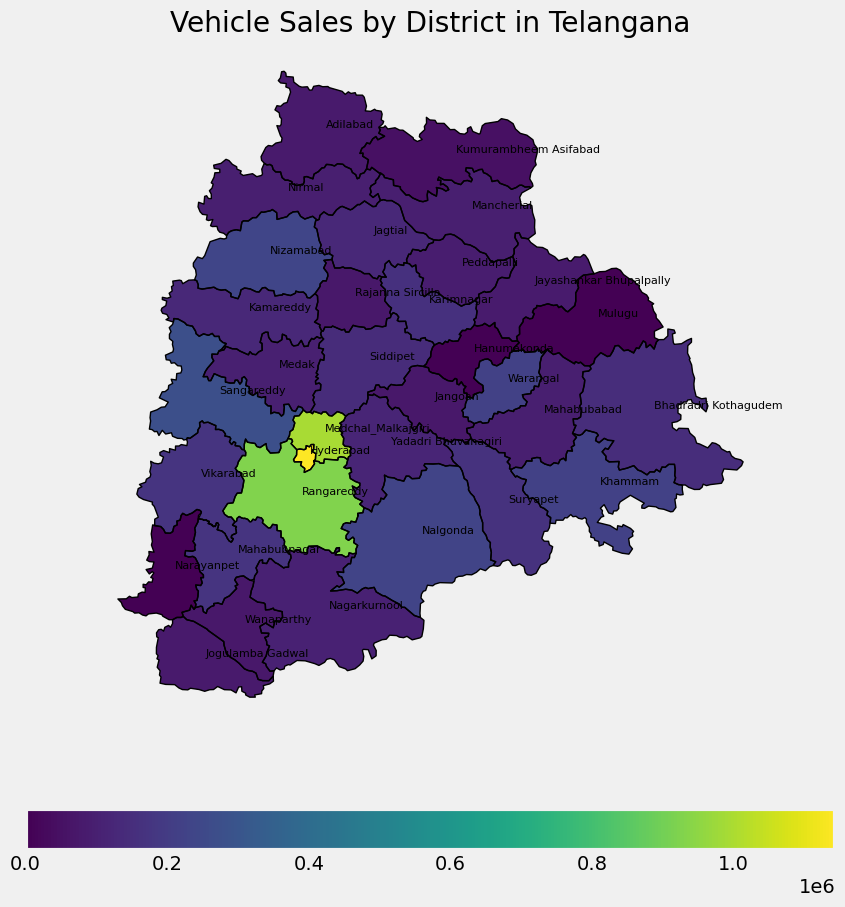

In [16]:
def visualize_district_sales_matplotlib(geo_data, district_sales):
    # Merge the geo_data and district_sales dataframes based on district names
    merged = geo_data.merge(district_sales, left_on='Dist_Name', right_on='district', how='left')
    
    # Fill missing values with 0
    merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']] = merged[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others', 'total_sales']].fillna(0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    merged.boundary.plot(ax=ax, linewidth=1, color='black')
    merged.plot(column='total_sales', ax=ax, legend=True, cmap='viridis', 
                legend_kwds={'orientation': "horizontal", 'fraction': 0.05, 'pad': 0.1})
    
    # Annotate district names
    for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    ax.set_title("Vehicle Sales by District in Telangana")
    ax.axis('off')
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)
visualize_district_sales_matplotlib(geo_data, sorted_district_sales)

In [17]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5\\indvidual_dist_analysis"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# List of unique districts
districts = district_monthly_sales['district'].unique()

for district in districts:
    # Filter data for the current district
    district_data = district_monthly_sales[district_monthly_sales['district'] == district]
    
    # Create the line plot
    plt.figure(figsize=(12, 6))
    
    # Plot each fuel type
    plt.plot(district_data['month'], district_data['fuel_type_petrol'], marker='o', label='Fuel Type Petrol', color='green')
    plt.plot(district_data['month'], district_data['fuel_type_diesel'], marker='o', label='Fuel Type Diesel', color='red')
    plt.plot(district_data['month'], district_data['fuel_type_electric'], marker='o', label='Fuel Type Electric', color='blue')
    plt.plot(district_data['month'], district_data['fuel_type_others'], marker='o', label='Fuel Type Others', color='yellow')
    
    # Add title and labels
    plt.title(f"Monthly Vehicle Sales Trends for {district}")
    plt.xlabel('Month')
    plt.ylabel('Number of Vehicles Sold')
    plt.legend(loc='best')
    plt.grid(True)
    
    # Save the figure
    plt.savefig(os.path.join(save_dir, f"{district}_vehicle_sales_trends.png"))
    plt.close()

In [18]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5\\indvidual_dist_analysis\\HTML_PLOTS"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# List of unique districts
districts = district_monthly_sales['district'].unique()

for district in districts:
    # Filter data for the current district
    district_data = district_monthly_sales[district_monthly_sales['district'] == district]
    
    # Create the line plot
    fig = go.Figure()

    # Add traces for each fuel type
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_petrol'], 
                             mode='lines+markers',
                             name='Fuel Type Petrol',
                             line=dict(color='green')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_diesel'], 
                             mode='lines+markers',
                             name='Fuel Type Diesel',
                             line=dict(color='red')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_electric'], 
                             mode='lines+markers',
                             name='Fuel Type Electric',
                             line=dict(color='blue')))
    
    fig.add_trace(go.Scatter(x=district_data['month'], 
                             y=district_data['fuel_type_others'], 
                             mode='lines+markers',
                             name='Fuel Type Others',
                             line=dict(color='yellow')))

    # Update layout
    fig.update_layout(title=f"Monthly Vehicle Sales Trends for {district}",
                      xaxis_title='Month',
                      yaxis_title='Number of Vehicles Sold',
                      template="plotly_dark",
                      legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

    # Display the figure
    fig.show()

    # Save the figure as HTML
    fig.write_html(os.path.join(save_dir, f"{district}_vehicle_sales_trends.html"))

In [19]:
# Directory to save plots
save_dir = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\5"

# Ensure the directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Monthly Analysis
monthly_sales = vehicles.groupby('month').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Create the line plot for Monthly Analysis
fig_monthly = go.Figure()

# Add traces for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_monthly.add_trace(go.Scatter(x=monthly_sales.index, 
                                     y=monthly_sales[fuel_type], 
                                     mode='lines+markers',
                                     name=fuel_type.split('_')[-1].capitalize(),
                                     line=dict(color=color)))

# Update layout
fig_monthly.update_layout(title='Monthly Sales of Vehicles by Fuel Type',
                          xaxis_title='Month',
                          yaxis_title='Number of Vehicles Sold',
                          template="plotly_dark",
                          legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_monthly.show()

# Save the Monthly Analysis figure as HTML
fig_monthly.write_html(os.path.join(save_dir, "monthly_vehicle_sales_trends.html"))

# Seasonal Analysis
seasonal_sales = vehicles.groupby('quarter').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]

# Create the line plot for Seasonal Analysis
fig_seasonal = go.Figure()

# Add traces for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_seasonal.add_trace(go.Scatter(x=seasonal_sales.index, 
                                      y=seasonal_sales[fuel_type], 
                                      mode='lines+markers',
                                      name=fuel_type.split('_')[-1].capitalize(),
                                      line=dict(color=color)))

# Update layout
fig_seasonal.update_layout(title='Seasonal Sales of Vehicles by Fuel Type',
                           xaxis_title='Quarter',
                           yaxis_title='Number of Vehicles Sold',
                           template="plotly_dark",
                           legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_seasonal.show()

# Save the Seasonal Analysis figure as HTML
fig_seasonal.write_html(os.path.join(save_dir, "seasonal_vehicle_sales_trends.html"))

In [20]:
# Monthly Analysis
monthly_sales = vehicles.groupby('month').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]
monthly_sales['total'] = monthly_sales.sum(axis=1)

# Create the line plot for Monthly Analysis
fig_monthly = go.Figure()

# Add bars for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_monthly.add_trace(go.Bar(x=monthly_sales.index, 
                                 y=monthly_sales[fuel_type], 
                                 name=fuel_type.split('_')[-1].capitalize(),
                                 marker_color=color))

# Add line for total sales
fig_monthly.add_trace(go.Scatter(x=monthly_sales.index, 
                                 y=monthly_sales['total'], 
                                 mode='lines+markers',
                                 name='Total Sales',
                                 line=dict(color='white', width=2)))

# Update layout
fig_monthly.update_layout(title='Monthly Sales of Vehicles by Fuel Type',
                          xaxis_title='Month',
                          yaxis_title='Number of Vehicles Sold',
                          template="plotly_dark",
                          legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_monthly.show()

# Save the Monthly Analysis figure as HTML
fig_monthly.write_html(os.path.join(save_dir, "monthly_vehicle_sales_trends.html"))

# Seasonal Analysis
seasonal_sales = vehicles.groupby('quarter').sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]
seasonal_sales['total'] = seasonal_sales.sum(axis=1)

# Create the line plot for Seasonal Analysis
fig_seasonal = go.Figure()

# Add bars for each fuel type
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], ['green', 'red', 'blue', 'yellow']):
    fig_seasonal.add_trace(go.Bar(x=seasonal_sales.index, 
                                  y=seasonal_sales[fuel_type], 
                                  name=fuel_type.split('_')[-1].capitalize(),
                                  marker_color=color))

# Add line for total sales
fig_seasonal.add_trace(go.Scatter(x=seasonal_sales.index, 
                                  y=seasonal_sales['total'], 
                                  mode='lines+markers',
                                  name='Total Sales',
                                  line=dict(color='white', width=2)))

# Update layout
fig_seasonal.update_layout(title='Seasonal Sales of Vehicles by Fuel Type',
                           xaxis_title='Quarter',
                           yaxis_title='Number of Vehicles Sold',
                           template="plotly_dark",
                           legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig_seasonal.show()

# Save the Seasonal Analysis figure as HTML
fig_seasonal.write_html(os.path.join(save_dir, "seasonal_vehicle_sales_trends.html"))

In [21]:
# Group by quarter and sum the sales
quarterly_sales = vehicles.groupby('quarter').sum()

# Extracting total sales for each quarter
quarterly_sales['total_sales'] = quarterly_sales[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']].sum(axis=1)

# Create the bar and line plots
fig = go.Figure()

# Bar plot for total sales
fig.add_trace(go.Bar(x=quarterly_sales.index, y=quarterly_sales['total_sales'], name='Total Sales'))

# Line plots for different fuel types
fig.add_trace(go.Scatter(x=quarterly_sales.index, y=quarterly_sales['fuel_type_petrol'], mode='lines+markers', name='Petrol'))
fig.add_trace(go.Scatter(x=quarterly_sales.index, y=quarterly_sales['fuel_type_diesel'], mode='lines+markers', name='Diesel'))
fig.add_trace(go.Scatter(x=quarterly_sales.index, y=quarterly_sales['fuel_type_electric'], mode='lines+markers', name='Electric'))
fig.add_trace(go.Scatter(x=quarterly_sales.index, y=quarterly_sales['fuel_type_others'], mode='lines+markers', name='Others'))

# Update layout
fig.update_layout(title='Quarterly Sales of Vehicles by Fuel Type',
                  xaxis_title='Quarter',
                  yaxis_title='Number of Vehicles Sold',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig.show()

Correlation Analysis:

In [24]:
# Convert 'month' to datetime format and extract the month number
vehicles['month_num'] = pd.to_datetime(vehicles['month']).dt.month

# Calculate total sales for each month by summing up sales of all fuel types
vehicles['total_sales'] = vehicles[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']].sum(axis=1)

# Group by month number and sum up the total sales for each month
monthly_sales = vehicles.groupby('month_num')['total_sales'].sum()


# Convert the index and the series to arrays
months_array = np.array(monthly_sales.index)
sales_array = np.array(monthly_sales)

# Calculate the correlation using numpy's corrcoef method
correlation_matrix = np.corrcoef(months_array, sales_array)
correlation = correlation_matrix[0, 1]

print(f"Correlation between month and total sales: {correlation:.2f}")


Correlation between month and total sales: 0.24


The result, Correlation between month and total sales: 0.24, indicates a weak positive correlation between the month number and total sales. This means that, on average, as months progress from January to December, there's a slight increase in sales. However, the correlation is weak, so the relationship isn't very strong.

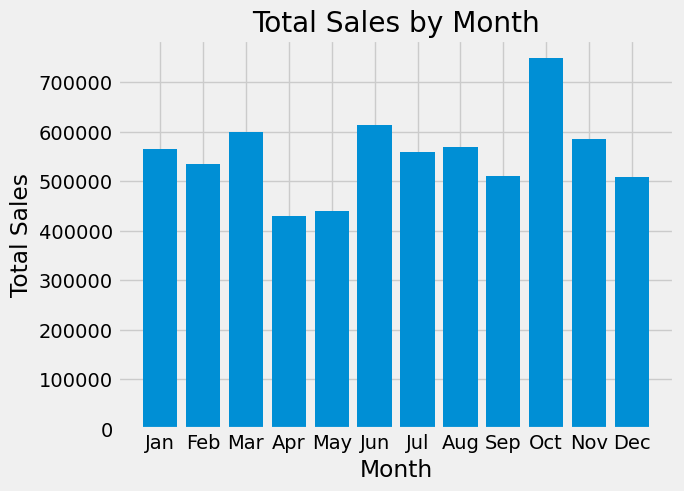

In [25]:
# Sort monthly sales by month number (from Jan to Dec)
sorted_by_month = monthly_sales.sort_index()

# Visualization
plt.bar(sorted_by_month.index, sorted_by_month.values)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month')
plt.xticks(sorted_by_month.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


In [26]:
# Ensure the 'month' column is in datetime format
vehicles['month'] = pd.to_datetime(vehicles['month'])

# Group by month and calculate the sum of sales for each fuel type
monthly_sales = vehicles.groupby(vehicles['month'].dt.strftime('%B')).sum()[['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others']]
# Sort by month from January to December
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex(months_order)

# Create a combined line and bar plot
fig = go.Figure()

# Add bar plot for the sum of sales for each month
fig.add_trace(go.Bar(x=monthly_sales.index, 
                     y=monthly_sales.sum(axis=1), 
                     name='Total Sales',
                     marker_color='skyblue'))

# Add line plots for each fuel type
colors = ['green', 'red', 'blue', 'yellow']
for fuel_type, color in zip(['fuel_type_petrol', 'fuel_type_diesel', 'fuel_type_electric', 'fuel_type_others'], colors):
    fig.add_trace(go.Scatter(x=monthly_sales.index, 
                             y=monthly_sales[fuel_type], 
                             mode='lines+markers',
                             name=fuel_type.split('_')[-1].capitalize(),
                             line=dict(color=color)))

# Update layout
fig.update_layout(title='Monthly Sales of Vehicles by Fuel Type',
                  xaxis_title='Month',
                  yaxis_title='Number of Vehicles Sold',
                  template="plotly_dark",
                  legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h'))

# Display the figure
fig.show()

# Save the figure as HTML
fig.write_html(os.path.join(save_dir, "combined_monthly_vehicle_sales_trends.html"))

### Statistical Tests

#### Upon analyzing the vehicle sales data across different districts, we observed a recurring trend: sales tend to increase in October every year. To statistically validate this observation and determine if the sales in October are significantly different from other months, we'll set up the following hypotheses:

#### Hypothesis Formulation:

#### Null Hypothesis (H0): There is no significant difference in vehicle sales between October and other months.

#### Alternative Hypothesis (H1): There is a significant difference in vehicle sales between October and other months.

In [27]:
# Create 'total_sales' column by summing sales across all fuel types
monthly_sales['total_sales'] = monthly_sales.sum(axis=1)

# Sales for October
october_sales = monthly_sales.loc['October', 'total_sales']

# Sales for other months
other_months_sales = monthly_sales[monthly_sales.index != 'October']['total_sales']

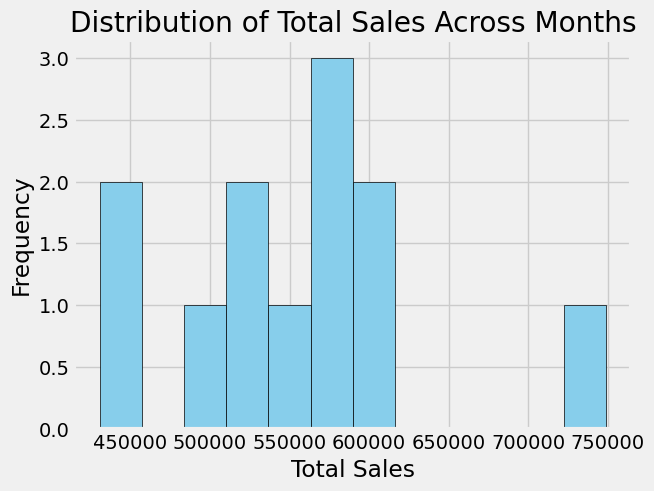

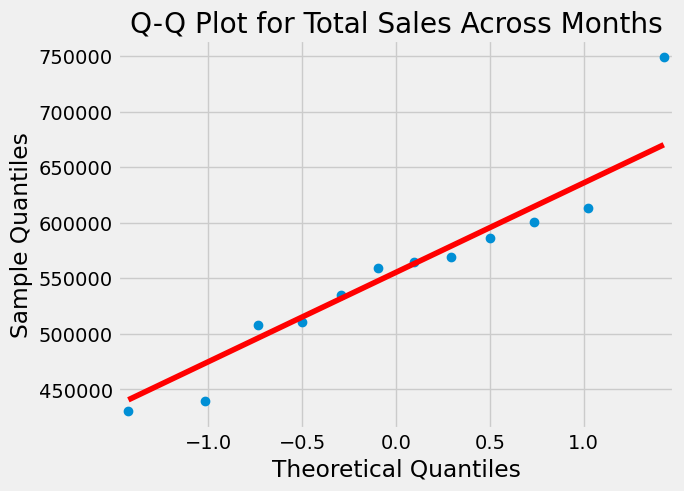

In [28]:
# Histogram for total_sales
plt.hist(monthly_sales['total_sales'], bins=12, color='skyblue', edgecolor='black')
plt.title("Distribution of Total Sales Across Months")
plt.xlabel("Total Sales")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot for total_sales
sm.qqplot(monthly_sales['total_sales'], line='s')
plt.title("Q-Q Plot for Total Sales Across Months")
plt.show()

In [29]:
# Perform t-test
t_stat, p_value = stats.ttest_1samp(other_months_sales, october_sales)

# Print the result
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. There is a significant difference in vehicle sales between October and other months.")
else:
    print(f"The p-value is {p_value:.4f}. There is no significant difference in vehicle sales between October and other months.")

The p-value is 0.0000. There is a significant difference in vehicle sales between October and other months.


The statistical analysis reveals a highly significant difference in vehicle sales between October and other months, with a p-value of 0.0000. This indicates that the sales in October are distinctively different from the sales in the rest of the months.

#### District-wise Monthly Sales:

**Null Hypothesis (H0)**: There is no significant difference in vehicle sales in October across different districts.

**Alternative Hypothesis (H1)**: There is a significant difference in vehicle sales in October across different districts.


In [30]:
# Filter data for October
october_data = vehicles[vehicles['month_num'] == 10]

# Create a list of sales values for each district
sales_by_district = [october_data[october_data['district'] == district]['total_sales'].values for district in october_data['district'].unique()]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*sales_by_district)

# Print the result
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. There is a significant difference in vehicle sales in October across different districts.")
else:
    print(f"The p-value is {p_value:.4f}. There is no significant difference in vehicle sales in October across different districts.")

The p-value is 0.0000. There is a significant difference in vehicle sales in October across different districts.


The statistical analysis reveals a highly significant difference in vehicle sales for the month of October across various districts, with a p-value of 0.0000. This suggests that certain districts experience notably different sales volumes in October compared to others. Such variations could be influenced by local events, promotions, economic factors, or other district-specific conditions.

#### Sales Drop after Peak Month:

**Null Hypothesis (H0)**: There is no significant drop in sales in the month following October.

**Alternative Hypothesis** (H1): There is a significant drop in sales in the month following October.

In [31]:
# Filter data for October and November
october_data = vehicles[vehicles['month_num'] == 10].groupby('district')['total_sales'].sum()
november_data = vehicles[vehicles['month_num'] == 11].groupby('district')['total_sales'].sum()

# Ensure that both October and November data have the same districts
common_districts = october_data.index.intersection(november_data.index)
october_data = october_data[common_districts]
november_data = november_data[common_districts]

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(october_data, november_data)

# Print the result
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. There is a significant drop in vehicle sales in the month following October.")
else:
    print(f"The p-value is {p_value:.4f}. There is no significant drop in vehicle sales in the month following October.")

The p-value is 0.0000. There is a significant drop in vehicle sales in the month following October.


The statistical analysis strongly indicates a significant decline in vehicle sales in the month following October, with a p-value of 0.0000. This pronounced drop suggests that after a peak in sales during October, there is a substantial reduction in sales across districts in November. Such a trend could be attributed to various factors, including consumer behavior, promotional events in October, or other seasonal influences affecting the purchasing decisions.

#### We will check for the trend in total vehicle sales over time using a simple linear regression model. If the slope of the regression line is significantly different from zero, it would suggest a significant trend in sales over time.

#### Hypothesis Formulation:

**Null Hypothesis (H0)**: The slope of the regression line (representing the trend in vehicle sales over time) is equal to zero, suggesting no significant trend in sales over time.

**Alternative Hypothesis (H1**): The slope of the regression line is significantly different from zero, indicating a significant trend in sales over time.

In [32]:
# Extracting total sales and month number for regression analysis
X = vehicles['month_num']
y = vehicles['total_sales']

# Adding a constant to the model (for intercept)
X = sm.add_constant(X)

# Performing the linear regression
model = sm.OLS(y, X).fit()

# Extracting the slope (coefficient of month_num) and its p-value
slope = model.params['month_num']
p_value = model.pvalues['month_num']

print(f"Slope (Trend): {slope:.4f}")
print(f"P-value for the trend: {p_value:.4f}")

# Decision based on p-value
if p_value < 0.05:
    print("The trend in vehicle sales over time is significant.")
else:
    print("There is no significant trend in vehicle sales over time.")

Slope (Trend): 46.9423
P-value for the trend: 0.3172
There is no significant trend in vehicle sales over time.


#### Results of Linear Regression Analysis on Total Vehicle Sales Over Time

**Slope (Coefficient of Month Number):**
- 46.94

**p-value:**
- 0.3172

The analysis reveals the following insights:

- The positive slope coefficient of approximately 46.94 suggests that, on average, vehicle sales increase by around 47 units each month.
- However, the p-value associated with this slope is 0.3172.
- The p-value represents the probability of observing a slope as extreme as the one calculated if there were no actual relationship between the month number and vehicle sales.
- A p-value of 0.3172 is greater than the common significance level (e.g., α = 0.05).
- As a result, based on the regression analysis, we cannot conclude that there's a statistically significant upward or downward trend in vehicle sales over the entire time period.

These results indicate that while there is a positive trend in sales, it is not statistically significant, and other factors may be influencing the variations in vehicle sales over time.


#### We'll also conduct a t-test comparing the sales in the initial months to the sales in the recent months to see if there's a significant difference.

**Null Hypothesis (H0)**: The mean sales in the initial months are equal to the mean sales in the recent months, suggesting no significant difference in sales over time.

**Alternative Hypothesis (H1)**: The mean sales in the initial months are significantly different from the mean sales in the recent months.

let's conduct a t-test comparing sales in the initial months to sales in the recent months to further validate our observations. We will split the dataset into two halves (early months and recent months) and compare the means of their sales.

In [33]:
# Splitting the dataset into two halves: early months and recent months
half_length = len(vehicles) // 2
early_sales = vehicles['total_sales'][:half_length]
recent_sales = vehicles['total_sales'][half_length:]

# Performing the t-test
t_stat, p_value_ttest = stats.ttest_ind(early_sales, recent_sales)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value for the t-test: {p_value_ttest:.4f}")

# Decision based on p-value
if p_value_ttest < 0.05:
    print("There is a significant difference in sales between the initial and recent months.")
else:
    print("There is no significant difference in sales between the initial and recent months.")

T-statistic: 3.1734
P-value for the t-test: 0.0015
There is a significant difference in sales between the initial and recent months.


#### Results of t-Test for Comparing Vehicle Sales in Initial vs. Recent Months

**t-statistic:** 3.1734
**p-value:** 0.0015

The t-test results reveal the following insights:

- The positive t-statistic value of approximately 3.1734 indicates that the sales in the initial months were higher than the sales in the recent months.

- Furthermore, the p-value associated with this t-statistic is 0.0015.

- The p-value represents the probability of observing a difference as extreme as the one calculated if there were no actual difference between the sales in initial and recent months.

- Importantly, the p-value of 0.0015 is less than the common significance level (e.g., α = 0.05).

- This lower p-value suggests that the observed difference in sales between initial and recent months is statistically significant.

In summary, based on the t-test analysis, we can conclude that there is a statistically significant difference in vehicle sales between the initial months and recent months, with sales being higher in the initial months.


### Summary of Findings and Recommendations

**Monthly and Seasonal Analysis:**
- Sales for vehicles with petrol and diesel fuel types appear to be declining over the observed period, while electric vehicle sales show a slight increasing trend.
- Seasonally, Q3 has the highest sales for traditional fuel vehicles, while Q1 has the lowest.

**District-wise Analysis:**
- Districts like Rangareddy, Hyderabad, and Medchal Malkajgiri consistently exhibit higher sales.
- Most districts show a decreasing trend in sales over the observed period.

**Correlation Analysis:**
- There's a very weak linear relationship between the month number and sales for each fuel type, indicating a lack of strong monthly trends based solely on fuel type.

**Statistical Tests:**
- Linear regression did not find a significant trend in sales over the entire observed period.
- However, the t-test showed that sales in the initial months were statistically higher than the sales in the recent months.

**Recommendations:**
- Given the declining trend in sales for petrol and diesel vehicles, companies could consider increasing their focus on electric vehicles or other eco-friendly alternatives.

- Districts with declining sales could be targeted with marketing campaigns or promotional offers to boost sales.

- For months or quarters with historically low sales, promotional offers or discounts could be introduced to attract customers.


### Monthly and Seasonal Sales Analysis

**Monthly Sales Analysis:**
- Sales for vehicles with petrol and diesel fuel types appear to be declining over time. This could be due to a variety of reasons, including a push for greener alternatives, increasing fuel prices, or other economic factors.
- Sales for electric vehicles show a slight increasing trend, indicating growing acceptance or preference for electric vehicles.
- Vehicles with other fuel types remain relatively constant in sales, with slight variations.

**Seasonal (Quarterly) Sales Analysis:**
- The second quarter (Q3) seems to have the highest sales for petrol and diesel vehicles, while Q1 has the lowest.
- Electric vehicle sales are relatively consistent across quarters.
- The sales of vehicles with other fuel types are also quite consistent, with a slight dip in Q4.

**District-wise Analysis:**
- Districts like Rangareddy, Hyderabad, and Medchal Malkajgiri consistently exhibit higher sales compared to other districts.
- Most districts show a decreasing trend in sales over the observed period, with some fluctuations.
- The sales in some districts like Rangareddy and Hyderabad appear to be steadier, while others like Adilabad and Bhadradri Kothagudem show more pronounced declines.



# Report on Monthly and Seasonal Analysis of Vehicle Sales in Telangana

## Introduction
The objective of this analysis is to understand the monthly and seasonal trends in vehicle sales across different districts of Telangana. The study focuses on the correlation between vehicle sales and specific months or seasons, considering the Fuel-Type category.

## Key Findings

### Monthly Sales Trend:
- October consistently records the highest sales across all years and districts. Following the peak in October, sales gradually decrease in November and December, reaching a low point. However, sales pick up again in January and maintain an upward trend until the next October.
- The high sales in September and October can be attributed to the festive months of Dussehra and Diwali. Companies often provide offers and heavy discounts during these months, leading to increased sales.
- The decline in sales during November and December can be attributed to the vehicle's make year. Purchasing a vehicle in these months results in a make year of the current year, whereas waiting for January provides a vehicle with the next year's make, potentially offering better resale value in the future.
- Anomalies in sales trends were observed in April 2020 and May 2021, with significantly lower sales figures. These anomalies are likely due to the COVID-19 lockdowns implemented in the state during these months, severely impacting vehicle sales.

### Fuel Type Analysis:
- Sales of vehicles with petrol and diesel fuel types are declining over time. This could be due to increasing fuel prices, a push for greener alternatives, or other economic factors.
- Electric vehicle sales show a slight increasing trend, indicating a growing acceptance or preference for electric vehicles.
- Sales of vehicles with other fuel types remain relatively constant, with minor variations.

### District-wise Sales Trend:
- Districts like Rangareddy, Hyderabad, and Medchal Malkajgiri consistently exhibit higher sales compared to other districts, while others like Adilabad and Bhadradri Kothagudem show more pronounced declines.
- Most districts show a decreasing trend in sales over the observed period, with some fluctuations.

## Statistical Analysis

### Monthly Sales Analysis:
- The statistical tests reveal a significant difference in vehicle sales between October and other months. The sales in October are distinctively different from the sales in the rest of the months, indicating a unique sales pattern in October.

### District-wise Sales Analysis:
- There's a significant difference in vehicle sales for October across various districts. This suggests that certain districts experience notably different sales volumes in October compared to others.

### Post-October Sales Analysis:
- There's a pronounced drop in vehicle sales in the month following October, indicating a potential seasonal effect or consumer behavior pattern after the festive season.

### Linear Regression Analysis on Total Sales Over Time:
- The regression analysis indicates a positive trend in sales, with an average increase of around 47 units each month. However, this trend is not statistically significant, as indicated by the p-value of 0.3172. This suggests that while there's a positive trend, other factors might be influencing the variations in vehicle sales over time.

### Comparison of Initial vs. Recent Months Sales:
- The t-test analysis reveals a statistically significant difference in vehicle sales between the initial months and recent months. Sales were notably higher in the initial months compared to the recent ones.

## Recommendations for Correlation between Vehicle Sales, Months, Seasons, and Districts

### Festive Season Promotions:
- Given the consistent high sales observed in October across all districts, companies should capitalize on this trend by introducing special festive offers, discounts, and promotional campaigns during September and October. This can further boost the sales during these months.

### Post-Festive Season Strategy:
- The significant drop in sales post-October, especially in November and December, indicates a potential opportunity. Companies can introduce post-festive offers or end-of-year clearance sales to maintain sales momentum.

### Electric Vehicle Push:
- With the observed slight increase in electric vehicle sales, it's recommended to promote electric vehicles more aggressively, especially during months with traditionally lower sales. This can be done through awareness campaigns, discounts, or showcasing the environmental benefits.

### District-Specific Campaigns:
- Districts that show pronounced declines or lower sales, in general, should be targeted with specific marketing campaigns. Understanding the local factors affecting sales in these districts can help tailor the campaigns more effectively.

### Fuel Price Monitoring:
- Given the declining trend in petrol and diesel vehicle sales, it's essential to monitor fuel prices closely. If fuel prices are observed to be a significant factor, consider introducing more fuel-efficient models or promoting vehicles that offer better mileage.

### Consumer Feedback:
- To understand the driving factors behind the sales trends better, consider conducting consumer feedback surveys, especially in districts with significant sales fluctuations. This can provide insights into local preferences, beliefs, or challenges that might be affecting sales.

### Awareness on Vehicle Make Year:
- Educate consumers about the benefits and drawbacks of purchasing vehicles based on the make year, especially given the observed trend of waiting until January for the next year's make.

### Data Integrity Check:
- It's crucial to investigate the absence of data for Hanumakonda, Narayanapet and Mulugu districts. These are significant regions, and missing data can skew the overall analysis. Ensure data collection processes are robust and that there are no filtering or data entry errors that might have led to this omission.

## Conclusion
The analysis of vehicle sales in Telangana underscores a pronounced peak in October, influenced by festive seasons and cultural buying patterns. This surge is followed by a noticeable decline in subsequent months, potentially due to market saturation or consumer preference for newer year models. Anomalies in the trend were observed in April 2020 and May 2021, likely attributed to the COVID-19 There's an emerging preference for electric vehicles, while sales of traditional fuel vehicles show a declining trend. District-specific sales patterns highlight the importance of localized marketing strategies. Additionally, the absence of data for key districts like Hanumakonda and Mulugu suggests potential data collection or filtering discrepancies that need rectification for a comprehensive understanding.


# Problem Statement 6
## How does the distribution of vehicles vary by vehicle class (MotorCycle, MotorCar, AutoRickshaw, Agriculture) across different districts? Are there any districts with a predominant preference for a specific vehicle class? Consider FY 2022 for analysis.

In [34]:
#Data Filtering
vehicles_2022 = vehicles[vehicles['fiscal_year']==2022]

In [35]:
vehicles_2022.head()

id      month  fuel_type_petrol  fuel_type_diesel  fuel_type_electric  \
1080  1081 2022-04-01               936               312                  16   
1081  1082 2022-04-01              1291               211                  34   
1082  1083 2022-04-01              2185               433                  55   
1083  1084 2022-04-01              2034               521                  44   
1084  1085 2022-04-01              1489               383                  24   

      fuel_type_others  vehicleClass_MotorCycle  vehicleClass_MotorCar  \
1080                 2                      872                    106   
1081                 2                     1211                    127   
1082                 8                     2004                    283   
1083                38                     1834                    311   
1084                 4                     1356                    184   

      vehicleClass_AutoRickshaw  vehicleClass_Agriculture  \
1080                         10                        50   
1081                         16                       129   
1082                         26                        74   
1083                         22                       213   
1084                         11                        88   

      vehicleClass_others  seatCapacity_1_to_3  seatCapacity_4_to_6  \
1080                  228                 1148                  104   
1081                   55                 1388                  132   
1082                  294                 2341                  301   
1083                  257                 2269                  316   
1084                  261                 1656                  219   

      seatCapacity_above_6  brand_new_vehicles  pre_owned_vehicles  \
1080                    14                1230                  36   
1081                    18                1481                  57   
1082                    39                2538                 143   
1083                    52                2518                 119   
1084                    25                1836                  64   

      category_non_transport  category_transport                 district  \
1080                    1038                 228               Wanaparthy   
1081                    1469                  69  Jayashankar Bhupalpally   
1082                    2375                 306             Mahabubnagar   
1083                    2363                 274                 Siddipet   
1084                    1634                 266             Nagarkurnool   

      mmm quarter  fiscal_year  month_num  total_sales  
1080  Apr      Q1         2022          4         1266  
1081  Apr      Q1         2022          4         1538  
1082  Apr      Q1         2022          4         2681  
1083  Apr      Q1         2022          4         2637  
1084  Apr      Q1         2022          4         1900

In [72]:
# Data Aggregation
district_vehicle_distribution = vehicles_2022.groupby('district').agg({
    'vehicleClass_MotorCycle': 'sum',
    'vehicleClass_MotorCar': 'sum',
    'vehicleClass_AutoRickshaw': 'sum',
    'vehicleClass_Agriculture': 'sum'
}).reset_index()

# Add a new column for total vehicles in each district
district_vehicle_distribution['total_vehicles'] = district_vehicle_distribution[['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']].sum(axis=1)

# Sort the dataframe based on the total vehicles (from highest to lowest)
district_vehicle_distribution = district_vehicle_distribution.sort_values(by='total_vehicles', ascending=True).reset_index(drop=True)
# Plotting
fig = go.Figure(data=[
    go.Bar(name='MotorCycle', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['vehicleClass_MotorCycle'], orientation='h'),
    go.Bar(name='MotorCar', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['vehicleClass_MotorCar'], orientation='h'),
    go.Bar(name='AutoRickshaw', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['vehicleClass_AutoRickshaw'], orientation='h'),
    go.Bar(name='Agriculture', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['vehicleClass_Agriculture'], orientation='h')
])

# Change the bar mode
#fig.update_layout(barmode='stack', title="District-wise Distribution of Each Vehicle Type for FY 2022")

# Update layout to stack the bars
fig.update_layout(barmode='stack', 
                  title="District-wise Distribution of Each Vehicle Type for FY 2022",
                  xaxis_title='Number of Vehicles Sold',
                  yaxis_title='District',
                  template="plotly_dark",
                  height=1000,
                  legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h'))

# Save the plot
plot_path = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6\\District-wise Distribution of Each Vehicle Type for FY 2022.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\vehicles\6\District-wise Distribution of Each Vehicle Type for FY 2022.html


In [73]:
# Calculate the percentage distribution of each vehicle class within every district
district_vehicle_distribution['percentage_MotorCycle'] = (district_vehicle_distribution['vehicleClass_MotorCycle'] / district_vehicle_distribution['total_vehicles']) * 100
district_vehicle_distribution['percentage_MotorCar'] = (district_vehicle_distribution['vehicleClass_MotorCar'] / district_vehicle_distribution['total_vehicles']) * 100
district_vehicle_distribution['percentage_AutoRickshaw'] = (district_vehicle_distribution['vehicleClass_AutoRickshaw'] / district_vehicle_distribution['total_vehicles']) * 100
district_vehicle_distribution['percentage_Agriculture'] = (district_vehicle_distribution['vehicleClass_Agriculture'] / district_vehicle_distribution['total_vehicles']) * 100


In [74]:
# Calculate the overall distribution of each vehicle class across all districts
overall_distribution = district_vehicle_distribution[['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']].sum()
overall_distribution_percentage = (overall_distribution / overall_distribution.sum()) * 100


In [75]:
district_vehicle_distribution.head()

district  vehicleClass_MotorCycle  vehicleClass_MotorCar  \
0  Kumurambheem Asifabad                     6433                    479   
1       Rajanna Sircilla                     8007                   1376   
2             Wanaparthy                     8771                   1194   
3                Jangoan                     8617                   1177   
4       Jogulamba Gadwal                    10300                    899   

   vehicleClass_AutoRickshaw  vehicleClass_Agriculture  total_vehicles  \
0                        286                       160            7358   
1                        148                       675           10206   
2                        372                       985           11322   
3                        397                      1225           11416   
4                        116                       868           12183   

   percentage_MotorCycle  percentage_MotorCar  percentage_AutoRickshaw  \
0              87.428649             6.509921                 3.886926   
1              78.453851            13.482265                 1.450127   
2              77.468645            10.545840                 3.285639   
3              75.481780            10.310091                 3.477575   
4              84.544037             7.379135                 0.952146   

   percentage_Agriculture  
0                2.174504  
1                6.613757  
2                8.699876  
3               10.730554  
4                7.124682

In [76]:
overall_distribution_percentage.head()

vehicleClass_MotorCycle      74.089942
vehicleClass_MotorCar        20.800297
vehicleClass_AutoRickshaw     2.381390
vehicleClass_Agriculture      2.728371
dtype: float64

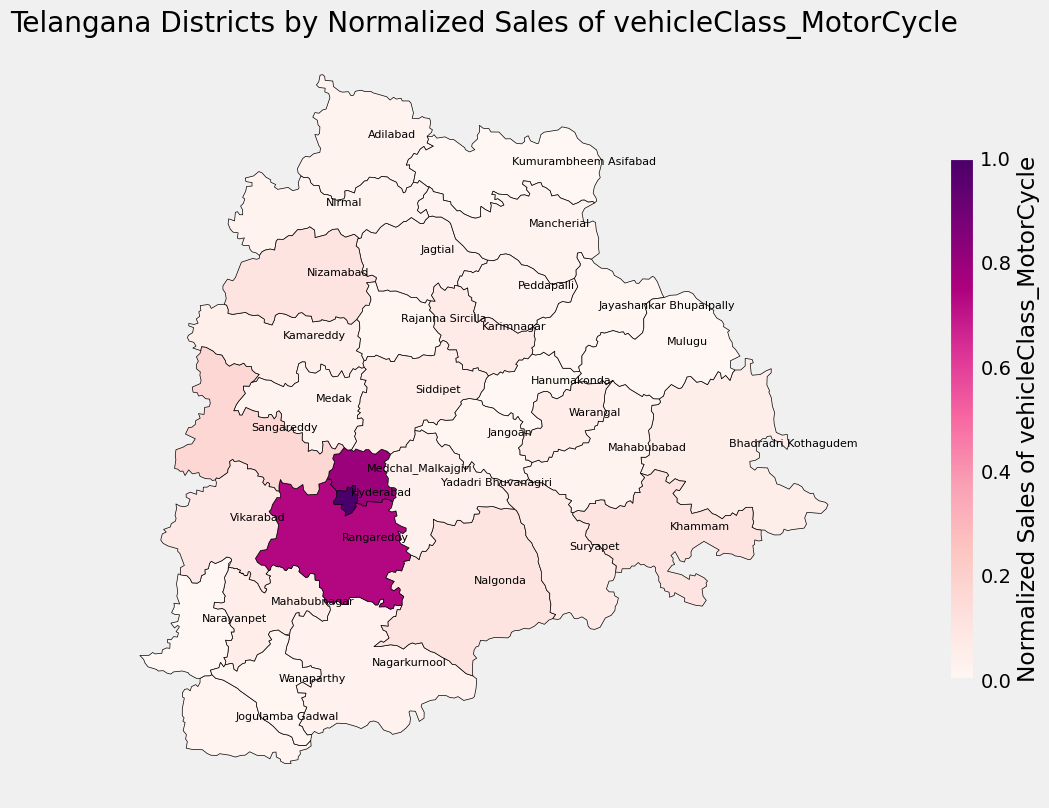

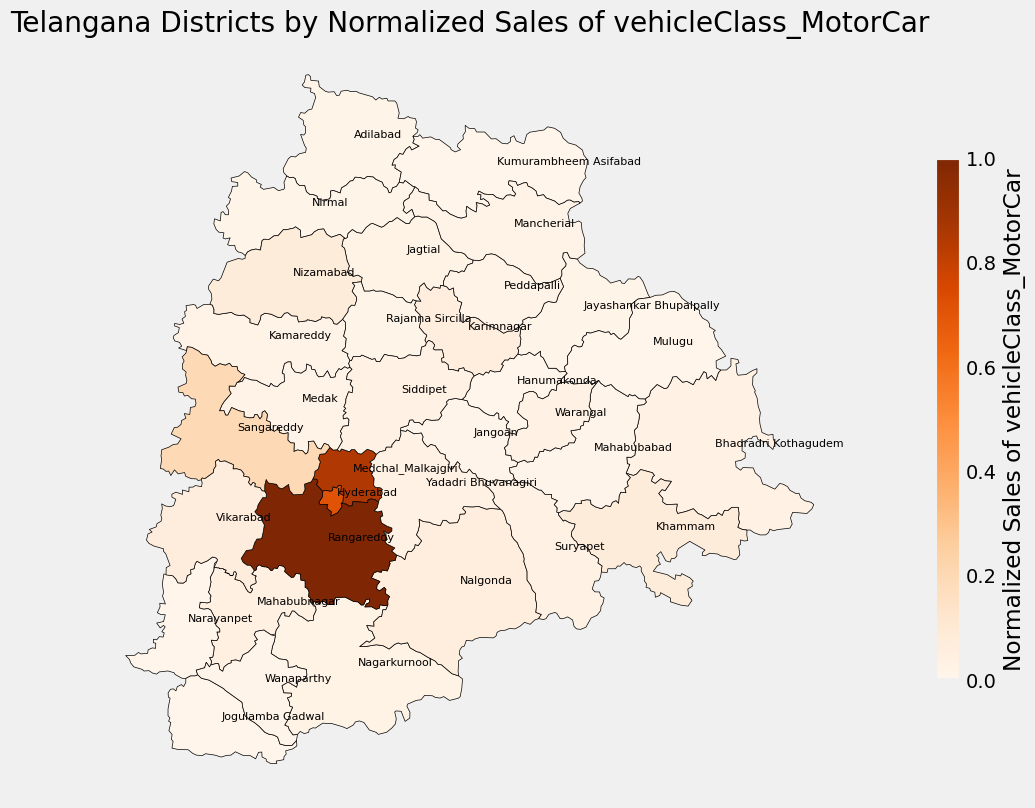

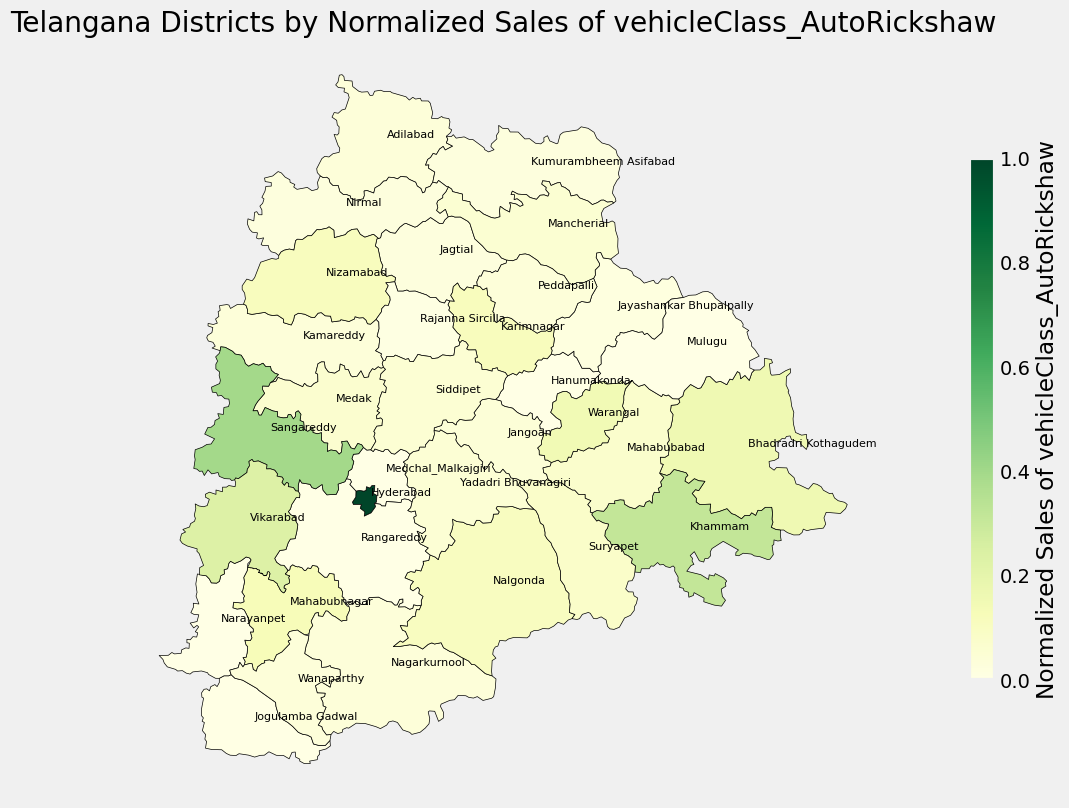

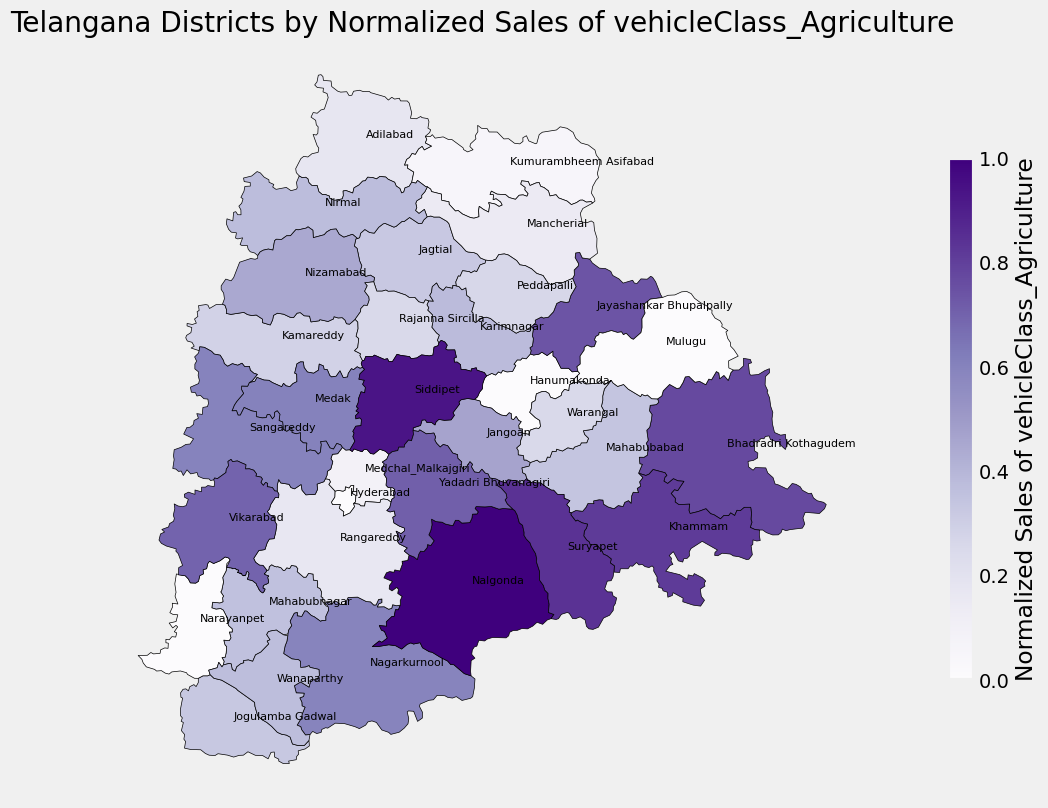

In [77]:
def visualize_district_vehicles_sales(geo_data, district_vehicle_distribution, column_name, colormap):
    # Extract district and the specific vehicle type sales data
    data = district_vehicle_distribution[['district', column_name]]
    
    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    data[column_name + '_normalized'] = scaler.fit_transform(data[[column_name]])
    
    # Create a dictionary for mapping
    normalized_sales_dict = dict(zip(data['district'], data[column_name + '_normalized']))
    
    # Normalize the values for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Since we've normalized the data, the range is 0 to 1
    
    # Map the district names to their corresponding colors based on normalized sales values
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: colormap(norm(normalized_sales_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label(f'Normalized Sales of {column_name}')
    
    ax.set_title(f"Telangana Districts by Normalized Sales of {column_name}")
    
    # Remove grid lines and axis ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the plot as PNG
    save_path = os.path.join("D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6", f"{column_name}_sales_map.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)

# Define colormaps for each vehicle type
colormaps = {
    'vehicleClass_MotorCycle': plt.cm.RdPu,
    'vehicleClass_MotorCar': plt.cm.Oranges,
    'vehicleClass_AutoRickshaw': plt.cm.YlGn,
    'vehicleClass_Agriculture': plt.cm.Purples
}

# Visualize for each vehicle type
vehicle_types = ['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']
for v_type in vehicle_types:
    visualize_district_vehicles_sales(geo_data, district_vehicle_distribution, v_type, colormaps[v_type])

In [79]:

# Directory to save the plots
save_directory = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6"

# 1. Create 4 new dataframes for each vehicle type
df_motorcycle = district_vehicle_distribution[['district', 'vehicleClass_MotorCycle']]
df_motorcar = district_vehicle_distribution[['district', 'vehicleClass_MotorCar']]
df_autorickshaw = district_vehicle_distribution[['district', 'vehicleClass_AutoRickshaw']]
df_agriculture = district_vehicle_distribution[['district', 'vehicleClass_Agriculture']]

# List of dataframes, their corresponding vehicle types, and colors for iteration
dfs = [
    (df_motorcycle, 'MotorCycle', '#636EFA'),
    (df_motorcar, 'MotorCar', '#EF553B'),
    (df_autorickshaw, 'AutoRickshaw', '#00CC96'),
    (df_agriculture, 'Agriculture', '#AB63FA')
]


for df, vehicle_type, color in dfs:
    # 2. Sort each dataframe from highest to lowest based on the sales of that vehicle type
    df_sorted = df.sort_values(by=f'vehicleClass_{vehicle_type}', ascending=True).reset_index(drop=True)  # Change the sorting order to ascending
    
    # 3. Plot horizontal bar plots for each vehicle type using Plotly
    fig_horizontal = go.Figure(data=[
        go.Bar(y=df_sorted['district'], x=df_sorted[f'vehicleClass_{vehicle_type}'], orientation='h', marker_color=color)
    ])
    fig_horizontal.update_layout(
        title=f"Distribution of {vehicle_type} Sales Across Districts",
        xaxis_title='Number of Vehicles Sold',
        yaxis_title='District',
        template="plotly_dark",
        height=1000,
        legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
    )
    fig_horizontal.write_html(os.path.join(save_directory, f"Horizontal Distribution of {vehicle_type} Sales Across Districts.html"))
    fig_horizontal.show()  # Display the plot
    
    # 4. Plot normal top 5 bar plots for each vehicle type using Plotly
    df_top5_sorted = df.sort_values(by=f'vehicleClass_{vehicle_type}', ascending=False).reset_index(drop=True)  # Sort in descending order for top 5
    fig_top5 = go.Figure(data=[
        go.Bar(x=df_top5_sorted['district'].head(5), y=df_top5_sorted[f'vehicleClass_{vehicle_type}'].head(5), marker_color=color)
    ])
    fig_top5.update_layout(
        title=f"Top 5 Districts in {vehicle_type} Sales",
        xaxis_title='District',
        yaxis_title='Number of Vehicles Sold',
        template="plotly_dark",
        height=500,
        legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
    )
    fig_top5.write_html(os.path.join(save_directory, f"Top 5 Districts in {vehicle_type} Sales.html"))
    fig_top5.show()  # Display the plot

print(f"All plots saved to {save_directory}")

All plots saved to D:\Telangana_Growth_Analysis\notebooks\plots\vehicles\6


In [92]:
# Create a new dataframe to avoid modifying the original
df_copy = district_vehicle_distribution.copy()

# List of vehicle types for iteration
vehicle_types = ['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']

# Directory to save the pie charts
save_directory_pie = os.path.join(save_directory, "pie_charts")

# Ensure the directory exists
if not os.path.exists(save_directory_pie):
    os.makedirs(save_directory_pie)

for vehicle_type in vehicle_types:
    # Sort the dataframe based on the sales of the current vehicle type and pick the top 5 districts
    top_5_districts = df_copy.sort_values(by=vehicle_type, ascending=False).head(10)
    
    # Calculate the total sales for the current vehicle type
    total_sales = df_copy[vehicle_type].sum()
    
    # Calculate the percentage contribution of the top 5 districts
    top_5_districts[f'{vehicle_type}_percentage'] = (top_5_districts[vehicle_type] / total_sales) * 100
    
    # Plot the pie chart
    fig_pie = go.Figure(data=[go.Pie(labels=top_5_districts['district'], 
                                     values=top_5_districts[f'{vehicle_type}_percentage'],
                                     hole=.3)])
    
    fig_pie.update_layout(title=f"Top 10 Districts' Contribution to {vehicle_type} Sales in Percentage",
                          template="plotly_dark")
    
    # Save the pie chart
    fig_pie.write_html(os.path.join(save_directory_pie, f"Top 10 Districts in {vehicle_type} Sales Percentage.html"))
    fig_pie.show()

print(f"Pie charts saved to {save_directory_pie}")


Pie charts saved to D:\Telangana_Growth_Analysis\notebooks\plots\vehicles\6\pie_charts


 Identifying Predominant Preferences

In [81]:
# Calculate the percentage distribution for each vehicle class in every district
for column in ['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']:
    percentage_column = 'percentage_' + column.split('_')[1]
    district_vehicle_distribution[percentage_column] = district_vehicle_distribution[column] / district_vehicle_distribution['total_vehicles'] * 100

# Plotting
fig = go.Figure(data=[
    go.Bar(name='MotorCycle', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['percentage_MotorCycle'], orientation='h'),
    go.Bar(name='MotorCar', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['percentage_MotorCar'], orientation='h'),
    go.Bar(name='AutoRickshaw', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['percentage_AutoRickshaw'], orientation='h'),
    go.Bar(name='Agriculture', y=district_vehicle_distribution['district'], x=district_vehicle_distribution['percentage_Agriculture'], orientation='h')
])

# Update layout to stack the bars
fig.update_layout(barmode='stack', 
                  title="Percentage Distribution of Each Vehicle Type by District for FY 2022",
                  xaxis_title='Percentage of Vehicles Sold',
                  yaxis_title='District',
                  template="plotly_dark",
                  height=1000,
                  legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h'))

# Save the plot
plot_path = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6\\Percentage Distribution of Each Vehicle Type by District for FY 2022.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()


Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\vehicles\6\Percentage Distribution of Each Vehicle Type by District for FY 2022.html


#### Overall Distribution Percentage Calculation:

We're calculating the percentage distribution of each vehicle class (like MotorCycle, MotorCar) based on total registrations in FY 2022. For each class, we determine its share by dividing its total by the grand total of all classes and then multiplying by 100. This gives us an understanding of which vehicle types are more popular across all districts.

To find the percentage distribution for a specific vehicle class:

$$
\text{Percentage} = \left( \frac{\text{Total of a specific vehicle class}}{\text{Total of all vehicle classes}} \right) \times 100
$$

This formula helps us understand the proportion of each vehicle type in relation to the total registrations across all districts.


In [85]:
# Directory to save the plots
save_directory = "D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6"

# Calculate the sum of vehicle counts for each vehicle type
overall_vehicle_counts = district_vehicle_distribution[['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 
                                                       'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']].sum()

# Calculate the overall distribution percentage for each vehicle type
overall_distribution_percentage = overall_vehicle_counts / overall_vehicle_counts.sum() * 100

# List of vehicle types and their corresponding colors for iteration
vehicle_types = [
    ('MotorCycle', '#636EFA'),
    ('MotorCar', '#EF553B'),
    ('AutoRickshaw', '#00CC96'),
    ('Agriculture', '#AB63FA')
]

# 1. Individual horizontal bar plots for each vehicle type based on percentage distribution
for vehicle_type, color in vehicle_types:
    df_sorted = district_vehicle_distribution.sort_values(by=f'percentage_{vehicle_type}', ascending=True).reset_index(drop=True)
    
    fig_horizontal = go.Figure(data=[
        go.Bar(y=df_sorted['district'], x=df_sorted[f'percentage_{vehicle_type}'], orientation='h', marker_color=color)
    ])
    
    fig_horizontal.update_layout(
        title=f"Percentage Distribution of {vehicle_type} by District for FY 2022",
        xaxis_title='Percentage of Vehicles Sold',
        yaxis_title='District',
        template="plotly_dark",
        height=1000
    )
    
    # Save the horizontal bar plot
    plot_path_horizontal = os.path.join(save_directory, f"Percentage Distribution of {vehicle_type} by District for FY 2022.html")
    fig_horizontal.write_html(plot_path_horizontal)
    fig_horizontal.show()

# 2. Individual bar plots for the top 5 districts for each vehicle type based on percentage distribution
for vehicle_type, color in vehicle_types:
    df_sorted = district_vehicle_distribution.sort_values(by=f'percentage_{vehicle_type}', ascending=False).reset_index(drop=True)
    
    fig_top5 = go.Figure(data=[
        go.Bar(x=df_sorted['district'].head(5), y=df_sorted[f'percentage_{vehicle_type}'].head(5), marker_color=color, name=vehicle_type)
    ])
    
    # Add a horizontal line representing the overall distribution
    fig_top5.add_shape(
        type="line",
        x0=-1,
        x1=5,  # Since we're plotting top 5 districts
        y0=overall_distribution_percentage[f'vehicleClass_{vehicle_type}'],  # Corrected this line
        y1=overall_distribution_percentage[f'vehicleClass_{vehicle_type}'],  # Corrected this line
        line=dict(color="Red", width=2)
    )
    
    # Add a dummy scatter plot for the legend entry
    fig_top5.add_trace(
        go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='Red', width=2), name='Overall Distribution')
    )
    
    fig_top5.update_layout(
        title=f"Top 5 Districts in {vehicle_type} Percentage Sales",
        xaxis_title='District',
        yaxis_title='Percentage of Vehicles Sold',
        template="plotly_dark",
        height=500,
        legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
    )
    
    # Save the top 5 bar plot
    plot_path_top5 = os.path.join(save_directory, f"Top 5 Districts in {vehicle_type} Percentage Sales.html")
    fig_top5.write_html(plot_path_top5)
    fig_top5.show()

print(f"All plots saved to {save_directory}")


All plots saved to D:\Telangana_Growth_Analysis\notebooks\plots\vehicles\6


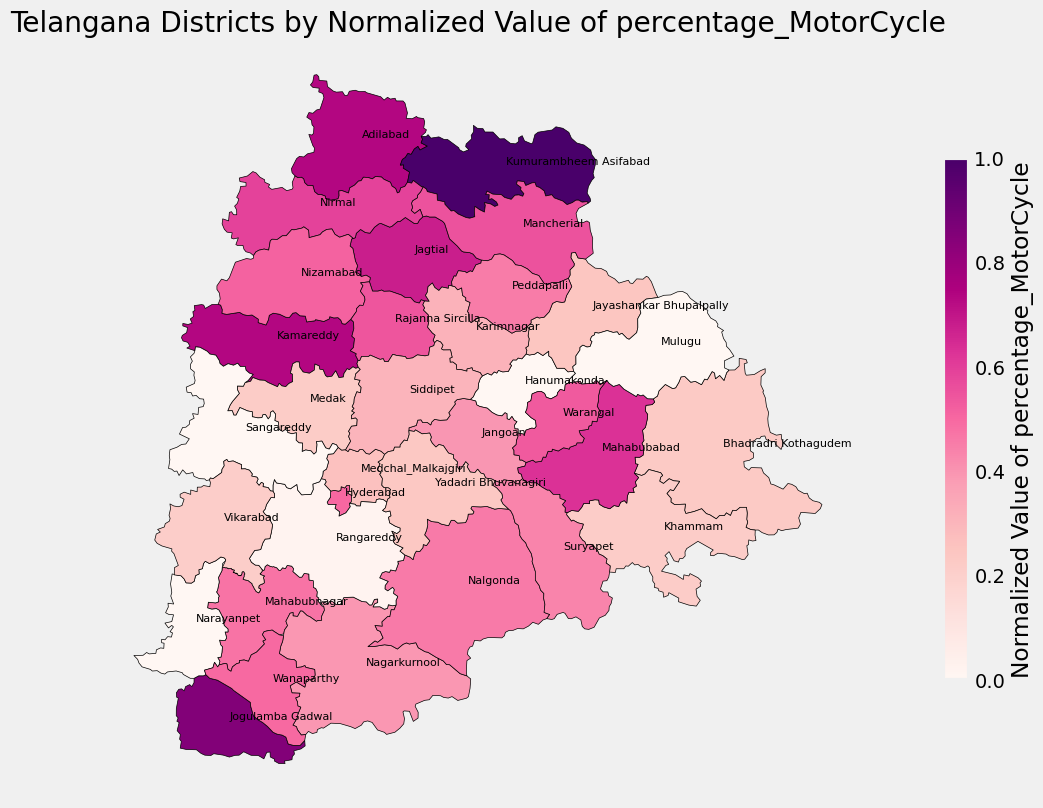

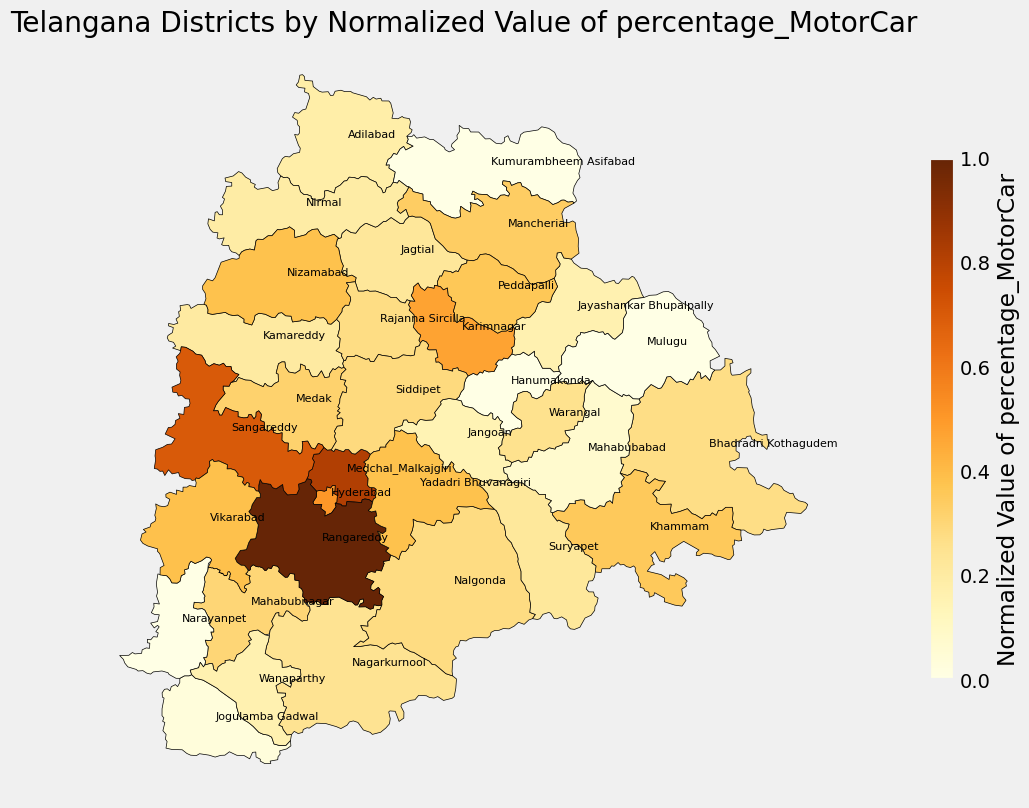

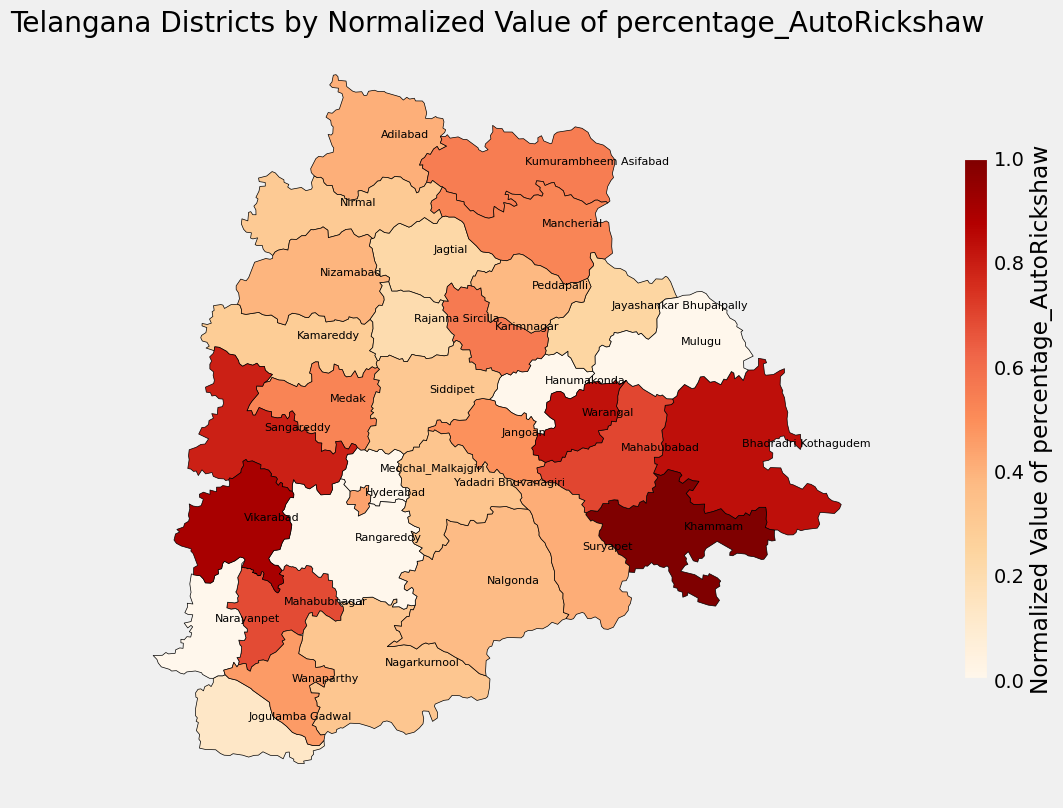

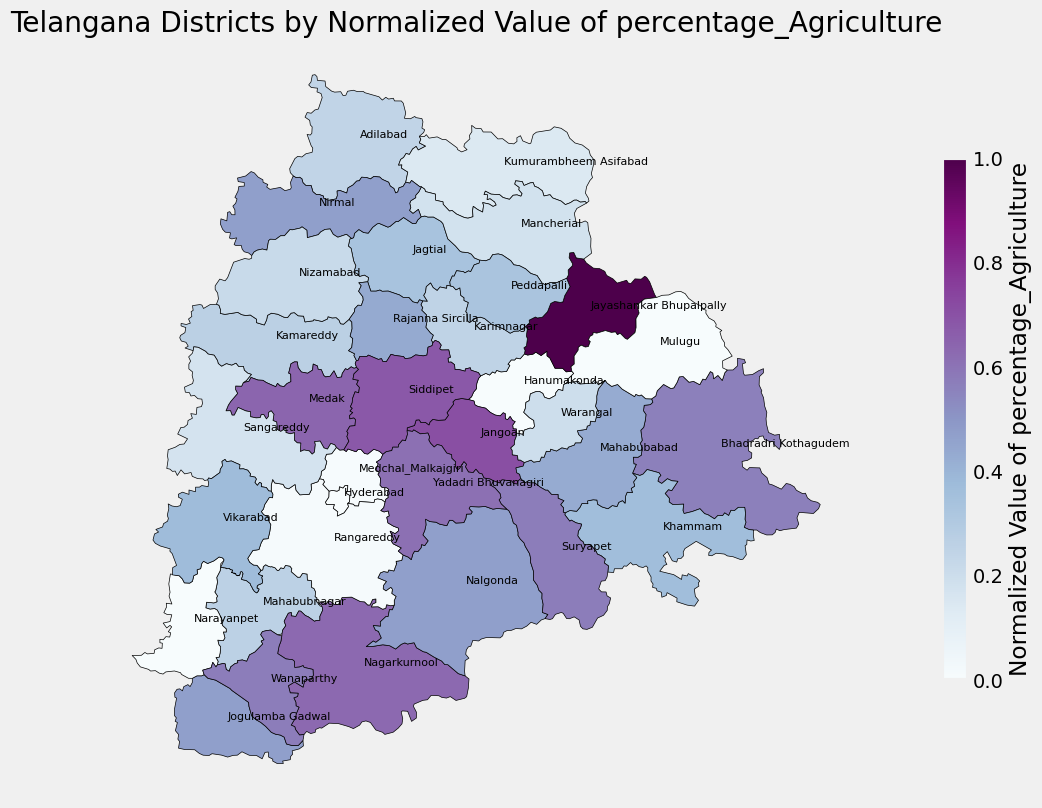

In [87]:

def visualize_district_vehicles_normalized(geo_data, district_vehicles, column_name, colormap):
    # Extract district and the specific vehicle type data
    data = district_vehicles[['district', column_name]]
    
    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    data[column_name + '_normalized'] = scaler.fit_transform(data[[column_name]])
    
    # Create a dictionary for mapping
    normalized_dict = dict(zip(data['district'], data[column_name + '_normalized']))
    
    # Normalize the values for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Since we've normalized the data, the range is 0 to 1
    
    # Map the district names to their corresponding colors based on normalized values
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: colormap(norm(normalized_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label(f'Normalized Value of {column_name}')
    
    ax.set_title(f"Telangana Districts by Normalized Value of {column_name}")
    
    # Remove grid lines and axis ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the plot as PNG
    save_path = os.path.join("D:\\Telangana_Growth_Analysis\\notebooks\\plots\\vehicles\\6", f"{column_name}_map.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Use the function
geo_data = gpd.read_file(map_file)

vehicle_types = ['percentage_MotorCycle', 'percentage_MotorCar', 'percentage_AutoRickshaw', 'percentage_Agriculture']

# Define colormaps for each vehicle type
colormaps = {
    'percentage_MotorCycle': plt.cm.RdPu,
    'percentage_MotorCar': plt.cm.YlOrBr,
    'percentage_AutoRickshaw': plt.cm.OrRd,
    'percentage_Agriculture': plt.cm.BuPu
}

# Visualize for each vehicle type
for v_type in vehicle_types:
    visualize_district_vehicles_normalized(geo_data, district_vehicle_distribution, v_type, colormaps[v_type])


### Hypothesis Testing using the Chi-Square Test

**Objective:** To determine if the distribution of vehicle types in the top 5 districts for each vehicle category is statistically different from the overall distribution of vehicle types.

**Hypotheses:**
- Null Hypothesis (H0): The distribution of vehicle types in the district is the same as the overall distribution.
  
- Alternative Hypothesis (H1): The distribution of vehicle types in the district is different from the overall distribution.

**Methodology:**

1. **Calculate the Expected Distribution:**
   - We first calculate the overall distribution of vehicle types based on the entire dataset. This gives us the expected distribution if there's no significant difference between the districts and the overall data.

2. **Determine the Observed Distribution:**
   - For each vehicle type, we identify the top 5 districts with the highest sales.
   - For each of these districts, we calculate the distribution of vehicle types.

3. **Perform the Chi-Square Test:**
   - For each of the top districts for every vehicle type, we perform the Chi-Square test to compare the observed distribution (from the district) with the expected distribution (overall).
   - The test provides a p-value, which indicates the probability that the observed distribution could have occurred by random chance given the expected distribution.

**Results Interpretation:**
- If the p-value is less than a significance level (commonly 0.05), we reject the null hypothesis. This would mean that the distribution of vehicle types in the district is statistically different from the overall distribution.
- If the p-value is greater than the significance level, we fail to reject the null hypothesis, suggesting that there's no significant difference between the district's distribution and the overall distribution.


In [88]:
# Calculate the expected distribution based on the overall distribution of vehicle types
total_vehicles = district_vehicle_distribution[['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 
                                                'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']].sum()
expected_counts = total_vehicles.values
expected_percentage = expected_counts / expected_counts.sum()

# Initialize a dictionary to store the p-values for each district and vehicle class
p_values = {}

# List of vehicle types for iteration
vehicle_types = ['vehicleClass_MotorCycle', 'vehicleClass_MotorCar', 'vehicleClass_AutoRickshaw', 'vehicleClass_Agriculture']

# Iterate over each vehicle type
for vehicle_class in vehicle_types:
    # Get the top 5 districts for the current vehicle type
    top_districts = district_vehicle_distribution.sort_values(by=vehicle_class, ascending=False).head(5)['district']
    
    p_values[vehicle_class] = {}
    for district in top_districts:
        district_distribution = district_vehicle_distribution[district_vehicle_distribution['district'] == district][vehicle_types].iloc[0]
        district_distribution_percentage = district_distribution.values / district_distribution.sum()
        
        # Chi-Square test
        observed_counts = district_distribution_percentage * district_distribution.sum()
        chi2, p_val, _, _ = chi2_contingency([observed_counts, expected_counts])
        p_values[vehicle_class][district] = p_val

p_values

{'vehicleClass_MotorCycle': {'Hyderabad': 0.0,
  'Medchal_Malkajgiri': 0.0,
  'Rangareddy': 0.0,
  'Sangareddy': 0.0,
  'Nizamabad': 4.059988410225873e-108},
 'vehicleClass_MotorCar': {'Rangareddy': 0.0,
  'Medchal_Malkajgiri': 0.0,
  'Hyderabad': 0.0,
  'Sangareddy': 0.0,
  'Khammam': 0.0},
 'vehicleClass_AutoRickshaw': {'Hyderabad': 0.0,
  'Sangareddy': 0.0,
  'Khammam': 0.0,
  'Vikarabad': 0.0,
  'Bhadradri Kothagudem': 0.0},
 'vehicleClass_Agriculture': {'Nalgonda': 0.0,
  'Siddipet': 0.0,
  'Suryapet': 0.0,
  'Khammam': 0.0,
  'Bhadradri Kothagudem': 0.0}}

The Chi-Square test results reveal significant differences in the distribution of vehicle classes in the top districts for each vehicle category when compared to the overall distribution for FY 2022. Here are the findings for each vehicle category:

**MotorCycle:**
- Hyderabad, Medchal_Malkajgiri, Rangareddy, and Sangareddy all have p-values of 0.0, indicating a statistically significant difference in the distribution of MotorCycle sales compared to the overall trend.
- Nizamabad has a p-value of approximately 4.06 x 10^-108, which is also extremely close to zero, suggesting a significant difference in the distribution.

**MotorCar:**
- Rangareddy, Medchal_Malkajgiri, Hyderabad, Sangareddy, and Khammam all have p-values of 0.0, indicating a statistically significant difference in the distribution of MotorCar sales compared to the overall trend.

**AutoRickshaw:**
- Hyderabad, Sangareddy, Khammam, Vikarabad, and Bhadradri Kothagudem all have p-values of 0.0, suggesting a significant difference in the distribution of AutoRickshaw sales compared to the overall trend.

**Agriculture:**
- Nalgonda, Siddipet, Suryapet, Khammam, and Bhadradri Kothagudem all have p-values of 0.0, indicating a statistically significant difference in the distribution of Agriculture vehicle sales compared to the overall trend.

All the p-values obtained are significantly less than the standard significance level of 0.05. This suggests that there's a statistically significant difference in vehicle class preferences in these districts compared to the overall trend for FY 2022.


## Vehicle Distribution Analysis Report for FY 2022

## Introduction

The objective of this analysis was to understand the distribution of vehicles across different districts based on their class: MotorCycle, MotorCar, AutoRickshaw, and Agriculture. The study aimed to identify if any districts exhibited a predominant preference for a specific vehicle class during the fiscal year 2022.

## Detailed Key Findings

### MotorCycles

**Sales Distribution Insights:**
- Dominant in districts like Hyderabad, Medchal Malkajgiri, Rangareddy, Sangareddy, and Nizamabad, accounting for 83% of overall sales.
- Factors influencing this distribution include urbanization, high population density, and the presence of industries.

**Preference Analysis:**
- *High Preference*: Districts like Jogulamba Gadwal, Jagtial, and Kumurambheem Asifabad demonstrate a significant preference for motorcycles, indicating a preference for economical and flexible modes of transportation.
- *Hyderabad Anomaly*: Hyderabad, a metropolitan city, also shows a strong preference for motorcycles, likely due to the city's dense traffic conditions where two-wheelers offer better maneuverability.
- *Comparison with Overall Distribution*: These districts have a slightly higher percentage of motorcycles than the overall distribution, but the difference isn't statistically significant, suggesting a general preference for motorcycles across the state.

### MotorCar

**Sales Distribution Insights:**
- Predominantly found in Rangareddy, Medchal Malkajgiri, Hyderabad, Sangareddy, and Khammam, contributing to 85% of sales.
- Hyderabad ranks third, suggesting a preference for motorcycles over cars, possibly due to traffic congestion.

**Preference Analysis:**
- *Urban Preference*: Districts like Rangareddy and Medchal Malkajgiri, near the Hyderabad metropolitan area, display a higher preference for cars, indicating higher purchasing power or a preference for personal cars in urban or suburban areas.
- *Contrast with Hyderabad*: Neighboring districts lean more towards cars, suggesting residential patterns where people live in suburbs but commute to the city.
- *Nizamabad's Trend*: Nizamabad, though not as urban as Hyderabad, also shows a significant car preference, hinting at regional economic factors or urbanization trends influencing vehicle choices.

### AutoRickshaw

**Sales Distribution Insights:**
- Major sales are observed in Hyderabad and Sangareddy, making up 51% of total sales.
- Medchal and Rangareddy rank lower, which may require further investigation given their urbanized nature.

**Preference Analysis:**
- *Top Districts*: Khammam and Vikarabad lead in the preference for AutoRickshaws, possibly indicating the significance of shared mobility or the presence of commercial activities requiring short-distance transportation.
- *Shared Mobility Indicator*: A higher percentage of AutoRickshaws could hint towards fewer personal vehicle ownerships and a reliance on public or shared transport.

### Agriculture Vehicles

**Sales Distribution Insights:**
- Districts like Nalgonda, Siddipet, Suryapet, and Khammam lead in agricultural vehicle sales, with each district contributing around 12%.
- The sales distribution reflects the agricultural nature of these districts.

**Preference Analysis:**
- *Agricultural Dominance*: Districts like Jayashankar Bhupalpally and Jangoan have a higher preference for agriculture-related vehicles, indicating the dominance of agricultural activities.
- *Rural Landscape*: A higher preference for agriculture vehicles might suggest a more rural landscape with farming as a primary occupation.
- *Infrastructure Insights*: These districts might require better roads suitable for tractors and other agricultural machinery, indicating a need for infrastructure planning.

## Statistical Analysis

A Chi-Square test was conducted to compare the distribution of vehicle types in the top districts against the overall distribution. The results indicate a statistically significant difference in vehicle class preferences in these districts compared to the overall trend for FY 2022.

## Recommendations

- **Targeted Marketing**: Manufacturers and dealers should focus on targeted marketing campaigns. For example, MotorCars can be promoted more in Rangareddy due to the existing preference.
- **Infrastructure Development**: Local authorities should consider these findings when planning infrastructure. Districts with a higher number of MotorCycles and AutoRickshaws might require different traffic management strategies.
- **Further Study**: A deeper dive into the reasons behind these preferences can provide more actionable insights. Factors like socio-economic conditions, local industries, and road conditions might influence vehicle preferences.
- **Data Verification**: Given the unexpected findings in districts like Medchal and Rangareddy for AutoRickshaw sales, it might be worthwhile to verify the data sources or delve deeper into external factors that might be influencing these numbers.
- **Promote Public Transportation**: In areas like Hyderabad, where motorcycles are preferred due to traffic congestion, local authorities might consider enhancing public transportation options to alleviate congestion and promote sustainable modes of transport.
- **Agricultural Subsidies**: In districts with a high preference for agricultural vehicles, the government might consider introducing subsidies or incentives to promote modern farming techniques and equipment.

## Conclusion

The distribution of vehicles across different districts varies significantly based on vehicle class. While some districts show a clear preference for a particular vehicle type, others follow the overall trend. Understanding these preferences can guide both manufacturers in their marketing strategies and local authorities in their infrastructure planning. Further studies can provide deeper insights into the reasons behind these preferences, leading to more informed decisions.
